In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

Let's start with these systems:

$P = 12.5 / (10s+1)$

$M = 14 / (10s+1)$

$f = 1 / (7s+1)$

$C = M^{-1} =  (10s+1) / 14$

In [12]:
import nengo
import numpy as np

P = nengo.synapses.LinearFilter(num=[12.5], den=[10, 1])
M = nengo.synapses.LinearFilter(num=[14], den=[10, 1])
f = nengo.synapses.LinearFilter(num=[1], den=[7, 1])
C = nengo.synapses.LinearFilter(num=[10, 1], den=[14])

model = nengo.Network()

with model:
    def r_func(t):
        freq = 0.02
        return np.sin(2*np.pi*freq*t)
    r = nengo.Node(r_func)
   
    r_total = nengo.Node(None, size_in=1)
    nengo.Connection(r, r_total, synapse=None)

    u = nengo.Node(None, size_in=1)
    nengo.Connection(r_total, u, synapse=f.combine(C))      

    y = nengo.Node(None, size_in=1)
    nengo.Connection(u, y, transform=1, synapse=P)

    y_m = nengo.Node(None, size_in=1)
    nengo.Connection(u, y_m, transform=1, synapse=M)
    
    y_diff = nengo.Node(None, size_in=1)
    nengo.Connection(y, y_diff, synapse=None)
    nengo.Connection(y_m, y_diff, transform=-1, synapse=None)
    nengo.Connection(y_diff, r_total, transform=-1, synapse=None)
    
    p_r = nengo.Probe(r)
    p_y = nengo.Probe(y)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

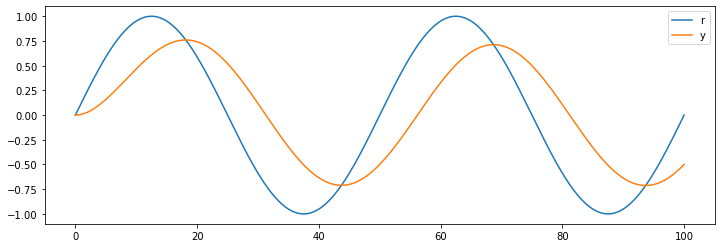

In [15]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_r], label='r')
plt.plot(sim.trange(), sim.data[p_y], label='y')
plt.legend()
plt.show()

In [11]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='imc.cfg')

c:\users\terry\git\nengo-gui\nengo_gui\jupyter.py:69: ConfigReuseWarning: Reusing config. Only the most recent visualization will update the config.
  warnings.warn(ConfigReuseWarning(


In [20]:
import nengo
import numpy as np

P = nengo.synapses.LinearFilter(num=[12.5], den=[10, 1])
M = nengo.synapses.LinearFilter(num=[14], den=[10, 1])
f = nengo.synapses.LinearFilter(num=[1], den=[7, 1])
C = nengo.synapses.LinearFilter(num=[10, 1], den=[14])

model = nengo.Network()

with model:
    def r_func(t):
        freq = 0.02
        return np.sin(2*np.pi*freq*t)
    r = nengo.Node(r_func)
   
    r_total = nengo.Node(None, size_in=1)
    nengo.Connection(r, r_total, synapse=None)

    fC = nengo.Node(f.combine(C))
    M = nengo.Node(M)
    P = nengo.Node(P)
    
    
    u = nengo.Node(None, size_in=1)
    nengo.Connection(r_total, fC, synapse=None)
    nengo.Connection(fC, u, None)      

    y = nengo.Node(None, size_in=1)
    nengo.Connection(u, P, synapse=None)
    nengo.Connection(P, y, synapse=None)

    y_m = nengo.Node(None, size_in=1)
    nengo.Connection(u, M, synapse=None)
    nengo.Connection(M, y_m, synapse=None)
    
    y_diff = nengo.Node(None, size_in=1)
    nengo.Connection(y, y_diff, synapse=None)
    nengo.Connection(y_m, y_diff, transform=-1, synapse=None)
    nengo.Connection(y_diff, r_total, transform=-1, synapse=0)
    
    p_r = nengo.Probe(r)
    p_y = nengo.Probe(y)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

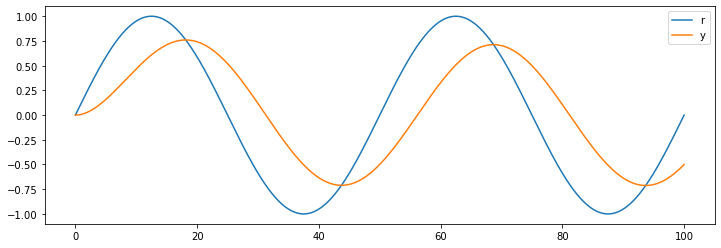

In [21]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_r], label='r')
plt.plot(sim.trange(), sim.data[p_y], label='y')
plt.legend()
plt.show()

In [22]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='imc2.cfg')

# Replacing M: Method 1

Now let's try replacing M with a set of neurons.  We'll do this in two different ways, just to demonstrate.

First, let's use the basic rule for replacing a differential equation with a group of recurrent neurons.  The rule is that if you can write a differential equation of the form $dy/dt = a(x) + b(y)$ and you want a recurrent group of neurons to approximate that differential equation, and your synapse is $1/(s \tau + 1)$, then you want to compute $f(x)=\tau a(x)$ on your input connection and $g(y)=\tau b(y) + y$ on your recurrent connection.

For this case, we have $M(s) = 14 / (10s+1)$.  If we want to write that as a differential equation, we get:

$Y/X = 14 / (10s+1)$

$10Ys+Y = 14X$

$sY = (14/10)X - (1/10)Y$

$dy/dt = (14/10)x(t) - (1/10)y(t)$

So on our input connection we want to compute the function $f(x)=\tau (14/10)x$ and our recurrent connection is $g(y)=-\tau (1/10)y + y$.  Let's try that.

In [46]:
import nengo
import numpy as np

P = nengo.synapses.LinearFilter(num=[12.5], den=[10, 1])
M = nengo.synapses.LinearFilter(num=[14], den=[10, 1])
f = nengo.synapses.LinearFilter(num=[1], den=[7, 1])
C = nengo.synapses.LinearFilter(num=[10, 1], den=[14])

model = nengo.Network()

with model:
    def r_func(t):
        freq = 0.02
        return np.sin(2*np.pi*freq*t)
    r = nengo.Node(r_func)
   
    r_total = nengo.Node(None, size_in=1)
    nengo.Connection(r, r_total, synapse=None)

    fC = nengo.Node(f.combine(C))
    M = nengo.Node(M)
    P = nengo.Node(P)
    
    
    u = nengo.Node(lambda t,x:x, size_in=1)
    nengo.Connection(r_total, fC, synapse=None)
    nengo.Connection(fC, u, None)      

    y = nengo.Node(None, size_in=1)
    nengo.Connection(u, P, synapse=None)
    nengo.Connection(P, y, synapse=None)

    y_m = nengo.Node(None, size_in=1)
    nengo.Connection(u, M, synapse=None)
    
    tau = 0.2
    neurons_M = nengo.Ensemble(n_neurons=500, dimensions=1,
                               neuron_type=nengo.LIF())
    def m_input(x):
        return tau*(14/10)*x
    def m_recurr(y):
        return -tau*(1/10)*y + y
    nengo.Connection(u, neurons_M, function=m_input, synapse=tau)
    nengo.Connection(neurons_M, neurons_M, function=m_recurr, synapse=tau)
    nengo.Connection(neurons_M, y_m, synapse=None)
    p_y_m = nengo.Probe(y_m, synapse=0.01)
    p_y_m_ideal = nengo.Probe(M, synapse=0.01)
    
    y_diff = nengo.Node(None, size_in=1)
    nengo.Connection(y, y_diff, synapse=None)
    nengo.Connection(y_m, y_diff, transform=-1, synapse=None)
    nengo.Connection(y_diff, r_total, transform=-1, synapse=0)
    
    p_r = nengo.Probe(r)
    p_y = nengo.Probe(y)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

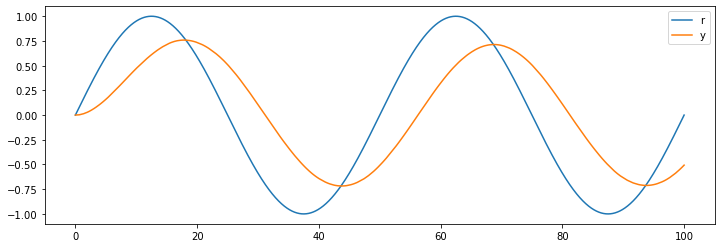

In [47]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_r], label='r')
plt.plot(sim.trange(), sim.data[p_y], label='y')
plt.legend()
plt.show()

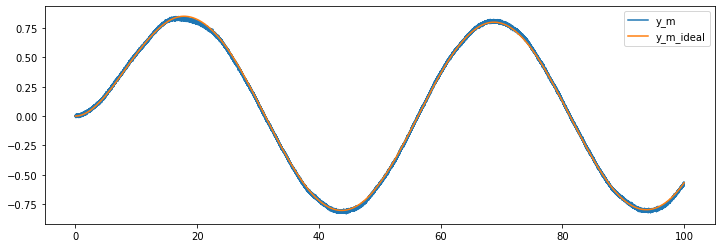

In [48]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_y_m], label='y_m')
plt.plot(sim.trange(), sim.data[p_y_m_ideal], label='y_m_ideal')
plt.legend()
plt.show()

# Replacing M: Method 2

Now let's try that again, but let's solve it in a different way.  In particular, let's not force ourselves to rewrite it as a differential equation. Instead, we'll derive everything from first principles, and we'll stay in the Laplace domain the whole time.

We have our desired system $M(s) = 14 / (10s+1)$.

If we build a recurrent neural network that has a $1/(\tau s + 1)$ synapse on its inputs, then we would have this system:

```
          +-----[G]-------+
          |               |
--- [F] --+-  1/(τs+1) ---+------
```

This turns into

$Y = (1/\tau s + 1)(G + F)$

$\tau sY + Y = G + F$

$\tau sY = G - Y + F$

Now, in order to implement a particular dynamical system, we just need to figure out what F and G should be.  In our case, we have

$M = Y / X = 14 / (10s + 1)$

$10sY + Y = 14 X$

$10sY = -Y +14 X$

$\tau sY = -(\tau/10)Y +(\tau/10)14 X$

So, $F(s) = (\tau/10) 14 X(s)$, giving us $f(x)=\tau(14/10)x$ and $G(s)=(-\tau/10)Y + Y$, giving us $g(y)=-\tau(1/10)y+y$.  These are the same equations as we got before!

# Replacing fC

Now let's try replacing fC with neurons.  First of all, replacing just f is easy -- it's exactly the same as what we did for M.  But the we'd have to try to replace C, which can't be done as that's not a physically realizable system.  So, let's combine the two together and then try to replace them both at once.

$f = 1 / (7s+1)$

$C = M^{-1} =  (10s+1) / 14$

$fC = (10s+1) / (14(7s+1))$

Now we have a bit of a problem.  This is a *proper* transfer function, but not a *strictly proper* transfer function.  So we won't be able to rewrite it as a differential equation.  However, we can do the standard trick of separating it into a strictly proper part and a constant part.  https://en.wikipedia.org/wiki/State-space_representation#Proper_transfer_functions

${{10s+1} \over {98s+14}} = {{10s+1 - (10/98)(98s+14)} \over {98s+14}}+(10/98){{98s+14} \over {98s+14}} = {{1-(10/98)14} \over {98s+14}}+10/98$

$ = {{-3/7} \over {98s+14}} + {10 \over 98}$

Now we can go ahead and implement this in neurons the same way as above, and add a direct connection that bypasses the neural network to implement the constant term.

In [66]:
import nengo
import numpy as np

P = nengo.synapses.LinearFilter(num=[12.5], den=[10, 1])
M = nengo.synapses.LinearFilter(num=[14], den=[10, 1])
f = nengo.synapses.LinearFilter(num=[1], den=[7, 1])
C = nengo.synapses.LinearFilter(num=[10, 1], den=[14])

model = nengo.Network()

with model:
    def r_func(t):
        freq = 0.02
        return np.sin(2*np.pi*freq*t)
    r = nengo.Node(r_func)
   
    r_total = nengo.Node(lambda t,x: x, size_in=1)
    nengo.Connection(r, r_total, synapse=None)

    fC = nengo.Node(f.combine(C))
    M = nengo.Node(M)
    P = nengo.Node(P)
    
    
    u = nengo.Node(lambda t,x:x, size_in=1)
    u_ideal = nengo.Node(lambda t,x:x, size_in=1)
    nengo.Connection(r_total, fC, synapse=None)
    nengo.Connection(fC, u_ideal, None)      
    
    tau_fC = 0.2
    neurons_fC = nengo.Ensemble(n_neurons=500, dimensions=1,
                                neuron_type=nengo.LIF(),
                               radius=0.2)
    def fC_input(x):
        return tau_fC*(-3/686)*x
    def fC_recurr(y):
        return -tau_fC/7*y+y
    nengo.Connection(r_total, neurons_fC, function=fC_input, synapse=tau_fC)
    nengo.Connection(neurons_fC, neurons_fC, function=fC_recurr, synapse=tau_fC)
    nengo.Connection(neurons_fC, u, synapse=None)
    nengo.Connection(r_total, u, transform=10/98, synapse=None)
    p_u = nengo.Probe(u, synapse=0.01)
    p_u_ideal = nengo.Probe(u_ideal, synapse=0.01)    
    

    y = nengo.Node(None, size_in=1)
    nengo.Connection(u, P, synapse=None)
    nengo.Connection(P, y, synapse=None)

    y_m = nengo.Node(None, size_in=1)
    nengo.Connection(u, M, synapse=None)
    
    tau_m = 0.2
    neurons_M = nengo.Ensemble(n_neurons=500, dimensions=1,
                               neuron_type=nengo.LIF())
    def m_input(x):
        return tau_m*(14/10)*x
    def m_recurr(y):
        return -tau_m*(1/10)*y + y
    nengo.Connection(u, neurons_M, function=m_input, synapse=tau_m)
    nengo.Connection(neurons_M, neurons_M, function=m_recurr, synapse=tau_m)
    nengo.Connection(neurons_M, y_m, synapse=None)
    p_y_m = nengo.Probe(y_m, synapse=0.01)
    p_y_m_ideal = nengo.Probe(M, synapse=0.01)
    
    y_diff = nengo.Node(None, size_in=1)
    nengo.Connection(y, y_diff, synapse=None)
    nengo.Connection(y_m, y_diff, transform=-1, synapse=None)
    nengo.Connection(y_diff, r_total, transform=-1, synapse=0)
    
    p_r = nengo.Probe(r)
    p_y = nengo.Probe(y)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

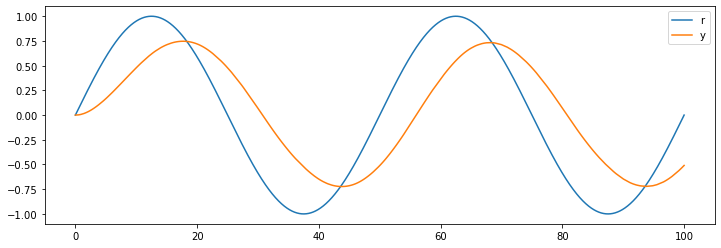

In [68]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_r], label='r')
plt.plot(sim.trange(), sim.data[p_y], label='y')
plt.legend()
plt.show()

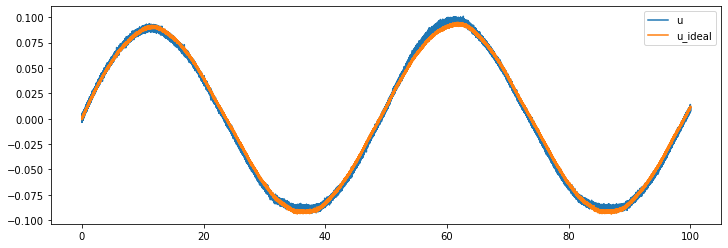

In [67]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_u], label='u')
plt.plot(sim.trange(), sim.data[p_u_ideal], label='u_ideal')
plt.legend()
plt.show()

In [69]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='imc3.cfg')

Looking at the network diagram, there are a few redundant nodes that could be removed.  For example, `u` isn't doing anything and so we could directly connect from `neurons_fC` to `P` and `neurons_M`.  We'd just need to be careful to also send `r_total` to those places as well.

We'll also remove those ideal calculations while we are at it.

In [72]:
import nengo
import numpy as np

P = nengo.synapses.LinearFilter(num=[12.5], den=[10, 1])
M = nengo.synapses.LinearFilter(num=[14], den=[10, 1])
f = nengo.synapses.LinearFilter(num=[1], den=[7, 1])
C = nengo.synapses.LinearFilter(num=[10, 1], den=[14])

model = nengo.Network()

with model:
    def r_func(t):
        freq = 0.02
        return np.sin(2*np.pi*freq*t)
    r = nengo.Node(r_func)
   
    r_total = nengo.Node(lambda t,x: x, size_in=1)
    nengo.Connection(r, r_total, synapse=None)

    P = nengo.Node(P)
    
    
    tau_fC = 0.2
    neurons_fC = nengo.Ensemble(n_neurons=500, dimensions=1,
                                neuron_type=nengo.LIF(),
                               radius=0.2)
    def fC_input(x):
        return tau_fC*(-3/686)*x
    def fC_recurr(y):
        return -tau_fC/7*y+y
    nengo.Connection(r_total, neurons_fC, function=fC_input, synapse=tau_fC)
    nengo.Connection(neurons_fC, neurons_fC, function=fC_recurr, synapse=tau_fC)
    nengo.Connection(neurons_fC, P, synapse=None)
    nengo.Connection(r_total, P, transform=10/98, synapse=None)

    

    y = nengo.Node(None, size_in=1)
    y_m = nengo.Node(None, size_in=1)
    nengo.Connection(P, y, synapse=None)

    
    tau_m = 0.2
    neurons_M = nengo.Ensemble(n_neurons=500, dimensions=1,
                               neuron_type=nengo.LIF())
    def m_input(x):
        return tau_m*(14/10)*x
    def m_recurr(y):
        return -tau_m*(1/10)*y + y
    nengo.Connection(neurons_fC, neurons_M, function=m_input, synapse=tau_m)
    nengo.Connection(r_total, neurons_M, transform=10/98, function=m_input, synapse=tau_m)    
    nengo.Connection(neurons_M, neurons_M, function=m_recurr, synapse=tau_m)
    nengo.Connection(neurons_M, y_m, synapse=None)
    
    y_diff = nengo.Node(None, size_in=1)
    nengo.Connection(y, y_diff, synapse=None)
    nengo.Connection(y_m, y_diff, transform=-1, synapse=None)
    nengo.Connection(y_diff, r_total, transform=-1, synapse=0)
    
    p_r = nengo.Probe(r)
    p_y = nengo.Probe(y)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(100)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

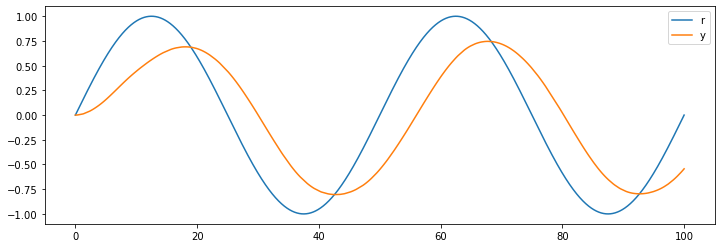

In [73]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_r], label='r')
plt.plot(sim.trange(), sim.data[p_y], label='y')
plt.legend()
plt.show()

In [74]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='imc4.cfg')

You could also remove `r_total` in a similar way.

# Other things to try

You could also combine f, C, and M all together and replace that with just one recurrent Ensemble.  

If you want to do higher-order filters, follow the same approach as when doing the canonical realizable form: https://en.wikipedia.org/wiki/State-space_representation#Canonical_realizations  

This is what we do for things like pure delays -- approximate the delays using the Pade approximation, and then implement the resulting dynamical system.